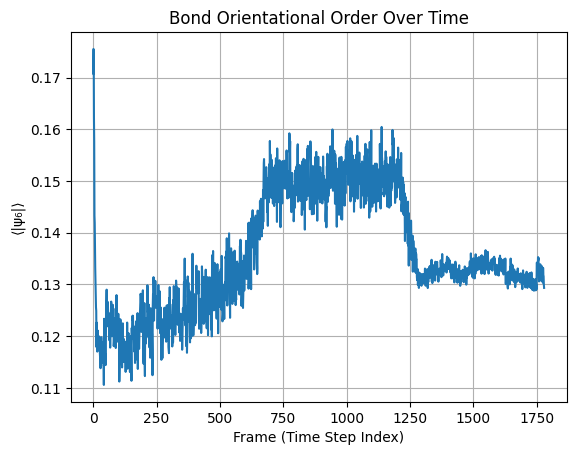

In [ ]:
from ase.io import read
from ase.neighborlist import NeighborList
import numpy as np
import matplotlib.pyplot as plt

traj = read("dump.catalysis_11_r3_2", index=":")  # all frames
cutoff = 1.8  # C-C neighbor distance
psi6_list = []
times = []

for i, atoms in enumerate(traj):
    cutoffs = [cutoff] * len(atoms)
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    psi6 = np.zeros(len(atoms), dtype=complex)

    for a in range(len(atoms)):
        indices, offsets = nl.get_neighbors(a)
        if len(indices) == 0:
            continue
        sum_exp = 0.0 + 0.0j
        for j in indices:
            dx = atoms[j].position[0] - atoms[a].position[0]
            dy = atoms[j].position[1] - atoms[a].position[1]
            theta = np.arctan2(dy, dx)
            sum_exp += np.exp(6j * theta)
        psi6[a] = sum_exp / len(indices)

    psi6_list.append(psi6)
    times.append(i)  # or atoms.info["step"] if available

# Now average ⟨|ψ₆|⟩ for each frame
avg_psi6 = [np.mean(np.abs(p)) for p in psi6_list]


1780


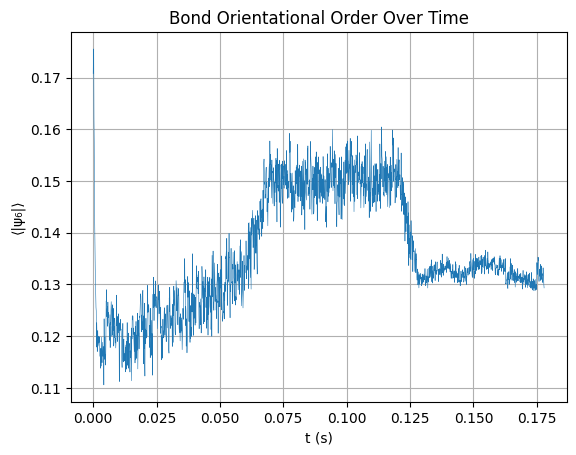

In [24]:
times=np.array(times)
avg_psi6=np.array(avg_psi6)
print(len(avg_psi6))

plt.plot(times*0.0001, avg_psi6, linewidth=0.4)
plt.xlabel("t (s)")
plt.ylabel("⟨|ψ₆|⟩")
plt.title("Bond Orientational Order Over Time")
plt.grid()
plt.show()

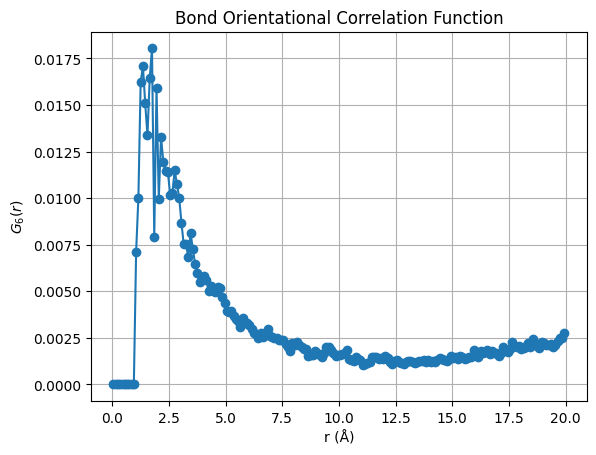

In [ ]:
def g6_r(positions, psi6, box, rmax=20.0, dr=0.1):
    """
    positions: Nx2 or Nx3 array of atom coords
    psi6: Nx1 array of complex psi6 for each atom
    box: simulation box info if needed (for PBC)
    returns: (r_values, G6_magnitude)
    """
    n = len(positions)
    nbins = int(rmax/dr)
    sum_corr = np.zeros(nbins, dtype=np.complex128)
    counts   = np.zeros(nbins, dtype=int)

    for i in range(n):
        for j in range(i+1, n):
            dx = positions[j,0] - positions[i,0]
            dy = positions[j,1] - positions[i,1]
            # (Apply PBC if needed)
            r_ij = np.sqrt(dx*dx + dy*dy)
            bin_index = int(r_ij/dr)
            if bin_index < nbins:
                sum_corr[bin_index] += psi6[i]*psi6[j].conjugate()
                counts[bin_index]   += 1

    # average
    G6 = np.zeros(nbins, dtype=np.complex128)
    for b in range(nbins):
        if counts[b] > 0:
            G6[b] = sum_corr[b] / counts[b]
    r_values = (np.arange(nbins) + 0.5)*dr
    return r_values, np.abs(G6)


import numpy as np
import matplotlib.pyplot as plt

# Suppose for each snapshot we compute G6 and then average across snapshots
all_G6 = []

for frame_idx, atoms in enumerate(traj):
    box = atoms.get_cell().array  # full 3x3 cell
    positions = atoms.get_positions()[:, :2]  # only xy for 2D

    r_values, G6_mag = g6_r(positions, psi6_list[frame_idx], box, rmax=20.0, dr=0.1)
    all_G6.append(G6_mag)

mean_G6 = np.mean(all_G6, axis=0)

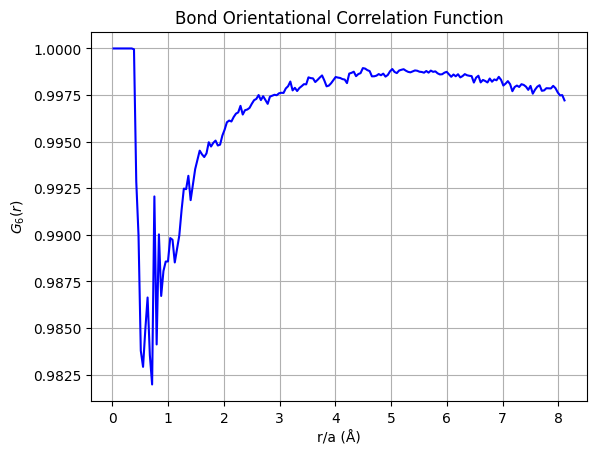

In [42]:
plt.plot(r_values/2.46, 1-mean_G6, linewidth=1.5, c='b')
plt.xlabel('r/a (Å)')
plt.ylabel(r'$G_6(r)$')
plt.title('Bond Orientational Correlation Function')
plt.grid(True)
plt.show()


In [ ]:
psi6_list = []      # list of psi6 arrays
G6_results = []     # list of (r, G6) for each frame
T_list = []         # store temp per snapshot

for frame_idx, atoms in enumerate(traj):
    step = atoms.info.get('step', frame_idx * 5000)  # get step if available
    T = 300 + (step / 2_000_000) * (5000 - 300)
    T_list.append(T)
    
    # Compute psi6
    psi6 = compute_psi6(atoms)
    psi6_list.append(psi6)
    
    # Compute G6(r)
    r, G6 = g6_r(atoms.positions[:, :2], psi6, rmax=20, dr=0.1)
    G6_results.append((r, G6))
